In [162]:
from Dataset import Dataset
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error
import sklearn.feature_selection
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    plot,
    loglog,
    semilogx,
    show,
    subplot,
    savefig,
    title,
    xlabel,
    ylabel,
)
from scipy import stats

from dtuimldmtools import bmplot, feature_selector_lr, rlr_validate



In [163]:
dataset = Dataset(original_data=False)
for i, n in enumerate(dataset.attributeNames):
    print(i, n)
attribute_to_predict = 3 # weight
y = dataset.X_mean_std[:, attribute_to_predict]  # we want to predcit the weight
X = np.delete(dataset.X_mean_std, attribute_to_predict, 1)  # delete fourth column out of matrix
# X = dataset.X_mean_std[:, 2] # height i think
attributeNames = np.delete(dataset.attributeNames, attribute_to_predict)
N, M = X.shape

0 Gender
1 Age
2 Height
3 Weight
4 family_history_with_overweight
5 NCP
6 CH2O
7 FAF
8 TUE
9 CALC
10 MTRANS
11 NObeyesdad


In [164]:
# Add offset attribute
# X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
# attributeNames = np.concatenate([np.array(["Offset"]), attributeNames])
# M = len(attributeNames)

In [165]:

def MSE(y_test, y_pred):
    return np.square(y_test - y_pred).sum(axis=0) / y_test.shape[0]

# Generalization Error per Lambda - Graph

Optimal lambda: 1e0.10000000000000187


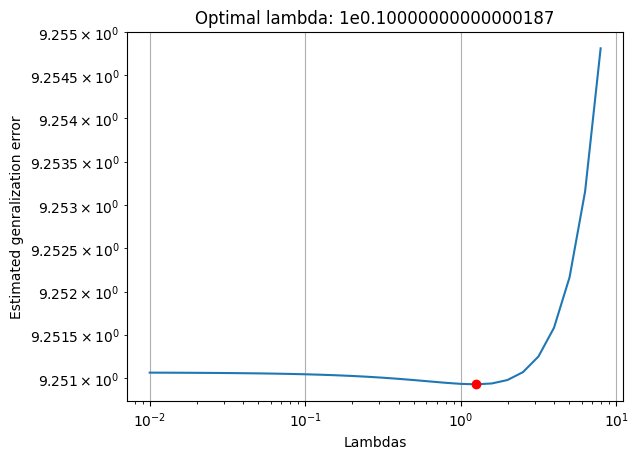

Gender : -0.032179392304974117
Age : -0.03649152415978584
Height : 0.35940031518830734
family_history_with_overweight : 0.028143256896395033
NCP : -0.009485695936050495
CH2O : 0.007361193161090027
FAF : 0.024492060452746163
TUE : -0.0034258236758391595
CALC : 0.026179473199476697
MTRANS : -0.009831811944207807
NObeyesdad : 0.8879960842194942


In [166]:
# generalization error as a function of lambda
lambdas = np.power(10,np.arange(-2, 1, 0.1).astype(float))
T = len(lambdas)
K = 10

CV = KFold(K, shuffle=True, random_state=20)

Error_per_lambda_train = np.empty((K, T)) # rows are errors of the test/train splits | cols are lambdas
Error_per_lambda_test = np.empty((K, T))
w_regularization = np.empty((M, T)) # rows are omegas for the atributs | cols are lambdas

k = 0
for train_index, test_index in CV.split(X, y):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # extract training and test set for current CV fold
    for i, l in enumerate(lambdas):
        lambdaI = l * np.eye(M)
        lambdaI[0, 0] = 0  # Do no regularize the bias term
        w_regularization[:, i] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
        # Compute mean squared error with regularization with optimal lambda
        Error_per_lambda_train[k, i] = (
            MSE(y_train, X_train @ w_regularization[:, i])
        )
        Error_per_lambda_test[k, i] = (
            MSE(y_test, X_test @ w_regularization[:, i])
        )

    k += 1

GenError_per_lamba_test = np.empty((T, 1))
GenError_per_lamba_train = np.empty((T, 1))

for i in range(T):
    # GenError_per_lamba_test[i] = np.mean(Error_per_lambda_test[:, i])
    # GenError_per_lamba_train[i] = np.mean(Error_per_lambda_train[:, i])
    GenError_per_lamba_test[i] = np.mean(Error_per_lambda_test[:, i]) * y_test.shape[0]
    GenError_per_lamba_train[i] = np.mean(Error_per_lambda_train[:, i]) * y_train.shape[0]


loglog(lambdas, GenError_per_lamba_test)
min_arg = np.argmin(GenError_per_lamba_test)
plot(lambdas[min_arg], GenError_per_lamba_test[min_arg], "ro", label="Optimal lambda")
optimal_lambda = np.log10(lambdas[min_arg])
print(f"Optimal lambda: 1e{optimal_lambda}")
title(f"Optimal lambda: 1e{optimal_lambda}")
grid()
xlabel("Lambdas")
ylabel("Estimated genralization error")
savefig("./figures/lin_reg_gen_lambdas.eps")
show()

for i in range(len(attributeNames)):
    print(f"{attributeNames[i]} : {w_regularization[i, min_arg]}")

# Two Layer-Cross Validation on regularized cross-validation

In [167]:
## Crossvalidation
# Create crossvalidation partition for evaluation
# Values of lambda
lambdas = np.power(10.0, np.arange(-1, 10, 1))
K = 10
CV = KFold(K, shuffle=True, random_state=20)


# Initialize variables
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))

w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

In [168]:
lambdas = np.power(10, np.arange(-4, 2, 1).astype(float))
T = len(lambdas)
Gen_error = np.empty((K, 1))
w_regularization = np.empty(
    (M, T)
)  # rows are omegas for the atributs | cols are lambdas
internal_cross_validation = K
k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)
    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    # 1: because the first paramter is offest
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]


    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # compute GenError for each model
    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
    y_test_pred = X_test @ w_rlr[:, k]
    print(
        f"optimal lambda = {opt_lambda} | Test error = {mean_squared_error(y_test, y_test_pred)}"
        # f"optimal lambda = {opt_lambda} | Test error = {MSE(y_test, y_test_pred) / y_test.shape[0]}"
    )
    k += 1

optimal lambda = 1.0 | Test error = 0.05157008995160865
optimal lambda = 1.0 | Test error = 0.04180615823375846
optimal lambda = 1.0 | Test error = 0.03835058035499598
optimal lambda = 1.0 | Test error = 0.0585291961439861
optimal lambda = 1.0 | Test error = 0.03941343903273985
optimal lambda = 1.0 | Test error = 0.04344750190406109
optimal lambda = 1.0 | Test error = 0.03722250689563224
optimal lambda = 1.0 | Test error = 0.039389979764172044
optimal lambda = 1.0 | Test error = 0.040212326146199476
optimal lambda = 1.0 | Test error = 0.04806982653246057
